# Deltas in Convective Mode

In [1]:
import xarray as xr
import xoak
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import regionmask
import cartopy
import cartopy.crs as ccrs
import glob
from scipy.stats import mannwhitneyu, levene

### Defintions

In [2]:
def Data_Conv(ds):
    
    '''
    A defintion  
    
    Parameters
    ----------
    ds: xarray dataset
    
    Returns
    -------
    ds_mask: a masked xarray dataset
    
    '''
    geog = xr.open_dataset("/home/scratch/ahaberlie/simgeog/geo_em.d01.nc")
    geog = geog[['CLAT', 'CLONG']].coarsen(south_north=20, west_east=20, boundary='trim').mean()
    
    ds = ds.coarsen(south_north=20, west_east=20, boundary='trim').sum()
    ds = xr.merge([ds, geog.squeeze()])
    ds = ds.rename({"CLONG": 'lon', 'CLAT': 'lat'})

    ds = ds.assign_coords({'x': ds.west_east, 'y': ds.south_north})
    ds = ds.assign_coords({'lon': ds.lon, 'lat': ds.lat})
    ds.xoak.set_index(['lat', 'lon'], 'sklearn_geo_balltree')
    
    #mask out area 
    ds_mask = mask_data(ds)
    
    
    return ds_mask

In [3]:
def convert_xy_to_latlon(points_in):

    geog = xr.open_dataset("/home/scratch/ahaberlie/simgeog/geo_em.d01.nc")

    lons = geog.CLONG.values[0,:,:]
    lats = geog.CLAT.values[0,:,:]
        
    points_in['lon'] = [lons[int(y), int(x)] for y, x in zip(points_in['y'], points_in['x'])]
    points_in['lat'] = [lats[int(y), int(x)] for y, x in zip(points_in['y'], points_in['x'])]

    gpd_points = gpd.GeoDataFrame(points_in, geometry=gpd.points_from_xy(points_in.lon, points_in.lat))

    gpd_points = gpd_points.set_crs('epsg:4269')
    
    return gpd_points

In [4]:
def mask_data(in_data):
    
    '''
    A defintion masking data in the US, east of the Rockies. 
    
    Parameters
    ----------
    in_data: xarray dataset
    
    Returns
    -------
    out_data: a masked xarray dataset
    
    '''
    
    usa = gpd.read_file("/home/jcorner1/Unidata/shapefiles/smoothing_econus.shp")

    state_mask = regionmask.mask_geopandas(usa, in_data.lon, in_data.lat)
    ma = state_mask.values
    ma[~np.isnan(ma)] = 1

    out_data = in_data * ma
    
    return out_data

In [5]:
from matplotlib.colors import ListedColormap, BoundaryNorm

def div_colorbar():
    
    div_colors = ['#053061',
                  '#2166ac',
                  '#4393c3',
                  '#92c5de',
                  '#d1e5f0',
                  '#f7f7f7',
                  '#fddbc7',
                  '#f4a582',
                  '#d6604d',
                  '#b2182b',
                  '#67001f'
                  ]
    
    cmap = ListedColormap(div_colors)
    
    return cmap

def div_boundarynorm():
    
    
    cmap = div_colorbar()
    classes = np.array(list(np.linspace(-22.5, 22.5, num=10)))
    norm = BoundaryNorm(classes, ncolors=cmap.N) 
    
    return cmap, norm

cmap, norm = div_boundarynorm()

In [6]:
def grid_significance(ds1, ds2, expected_dims=(15, 44, 69)):
    r"""Performs a grid-to-grid significance test on ds1 and ds2.
    Returns a grid of the same size with p-values from the Mann
    Whitney U test.
    
    Parameters
    ----------
    ds1: (t, y, x) ndarray
        An ndarray in the format of (time, y, x) and shape of expected_dims. 
    ds2: (t, y, x) ndarray
        An ndarray in the format of (time, y, x) and shape of expected_dims.  
    expected_dims: tuple
        The expected shape of ds1 and ds2. Default is (15, 44, 69).
        
    Returns
    -------
    results: (y, x) ndarray
        Results of significance testing in the form of p-values.
    """    
    
    if ds1.shape == expected_dims and ds2.shape == expected_dims:
        #Assumption of non-significance with all values == 1
        results = np.ones(shape=(ds1.shape[1], ds1.shape[2]), dtype=float)

        for i in range(ds1.shape[1]):
            for j in range(ds1.shape[2]):

                ds1_dist = ds1[:, i, j]
                ds2_dist = ds2[:, i, j]

                if np.mean(ds1_dist > 0) or np.mean(ds2_dist > 0):

                    s, p = mannwhitneyu(ds1_dist, ds2_dist)
                        
                    results[i, j] = p

        return results
    
    else:
        
        raise ValueError("Dimensions are not as expected, given", ds1.shape, "expected", expected_dims)

In [7]:
#open simple nc file to copy to
ds = xr.open_dataset('/home/scratch/ahaberlie/AFWA_2-5KM_UPDRAFT_HELICITY/HIST/1990-1991/UP_HELI_MAX_historical-1990-1991_1990-10-01.nc')
ds = ds.sel(Time ='1990-10-01T00:00:00.000000000')
ds_copy = ds.copy()
ds_copy

FileNotFoundError: [Errno 2] No such file or directory: b'/home/scratch/ahaberlie/AFWA_2-5KM_UPDRAFT_HELICITY/HIST/1990-1991/UP_HELI_MAX_historical-1990-1991_1990-10-01.nc'

In [ ]:
#create lists for the epochs and seasons
types = ['hist', 'eoc4p5', 'eoc8p5']
seasons = ['Winter', 'Spring', 'Summer', 'Fall']

#interate through the epochs
for epoch in types:
    csvs = []

    #find all CSVs with convective modes
    for csv in glob.glob(f"/home/scratch/jcorner1/Thesis/data/storm_mode/storm_modes_*_{epoch}.csv"):
        
        #
        svr_pts = pd.read_csv(csv, parse_dates=['Time'])
        svr_pts = convert_xy_to_latlon(svr_pts)
        csvs.append(svr_pts)

    #append the csvs together
    csvs = pd.concat(csvs, ignore_index=True)
    
    #seperate timing values into their own column
    csvs['Year'] = pd.to_datetime(csvs['Time']).dt.year
    csvs['Month'] = pd.to_datetime(csvs['Time']).dt.month
    csvs['Day'] = pd.to_datetime(csvs['Time']).dt.day
    csvs['Hour'] = pd.to_datetime(csvs['Time']).dt.time
    
    #iterate through the seasons
    for season in seasons:
        if season == 'Winter':
            locals()[f"csvs_{epoch}_{season}"] = csvs[((csvs['Month'] <= 2) | (csvs['Month'] == 12))]
            
        elif season == 'Spring':
            locals()[f"csvs_{epoch}_{season}"] = csvs[((csvs['Month'] >=3 ) & (csvs['Month'] <= 5))]
            
        elif season == 'Summer':
            locals()[f"csvs_{epoch}_{season}"] = csvs[((csvs['Month'] >=6 ) & (csvs['Month'] <= 8))]
            
        elif season == 'Fall':
            locals()[f"csvs_{epoch}_{season}"] = csvs[((csvs['Month'] >=9 ) & (csvs['Month'] <= 11))]
            
        

In [7]:
modes = ['Cellular', 'Multicell', 'Linear', 'Areal Systems']


#
for time in types:
    #
    for season in seasons:
        df = locals()[f"csvs_{time}_{season}"]

        #
        for mode in modes:

            #
            locals()[f'{mode}_blanks_{time}'] = np.zeros((899,1399))
            cur_mode = df[(df['Mode'] == mode)]

            #
            for rid, row in cur_mode.iterrows():
                locals()[f'{mode}_blanks_{time}'][row['y'], row['x']] = locals()[f'{mode}_blanks_{time}'][row['y'], row['x']] + 1

            #
            locals()[f'{mode}_blanks_{time}'][locals()[f'{mode}_blanks_{time}'] == 0.0] = np.nan
            locals()[f'ds_{mode}_{time}'] = ds_copy.assign(UP_HELI_MAX = (('south_north', 'west_east'), locals()[f'{mode}_blanks_{time}']))
            locals()[f'ds_cov_{mode}_{time}_{season}'] =  Data_Conv(locals()[f'ds_{mode}_{time}'])

In [8]:
#iterate through the modes and seasons
for mode in modes:
    for season in seasons:

        # subtract future from historic to calculate change
        # divide by 15 to show annuanal change 
        locals()[f'delta_4p5_hist_{mode}_{season}'] = locals()[f'ds_cov_{mode}_eoc4p5_{season}'].UP_HELI_MAX.values/15 - locals()[f'ds_cov_{mode}_hist_{season}'].UP_HELI_MAX.values/15
        locals()[f'delta_8p5_hist_{mode}_{season}'] = locals()[f'ds_cov_{mode}_eoc8p5_{season}'].UP_HELI_MAX.values/15 - locals()[f'ds_cov_{mode}_hist_{season}'].UP_HELI_MAX.values/15
        locals()[f'delta_8p5_4p5_{mode}_{season}'] = locals()[f'ds_cov_{mode}_eoc8p5_{season}'].UP_HELI_MAX.values/15 - locals()[f'ds_cov_{mode}_eoc4p5_{season}'].UP_HELI_MAX.values/15


## RCP 4.5

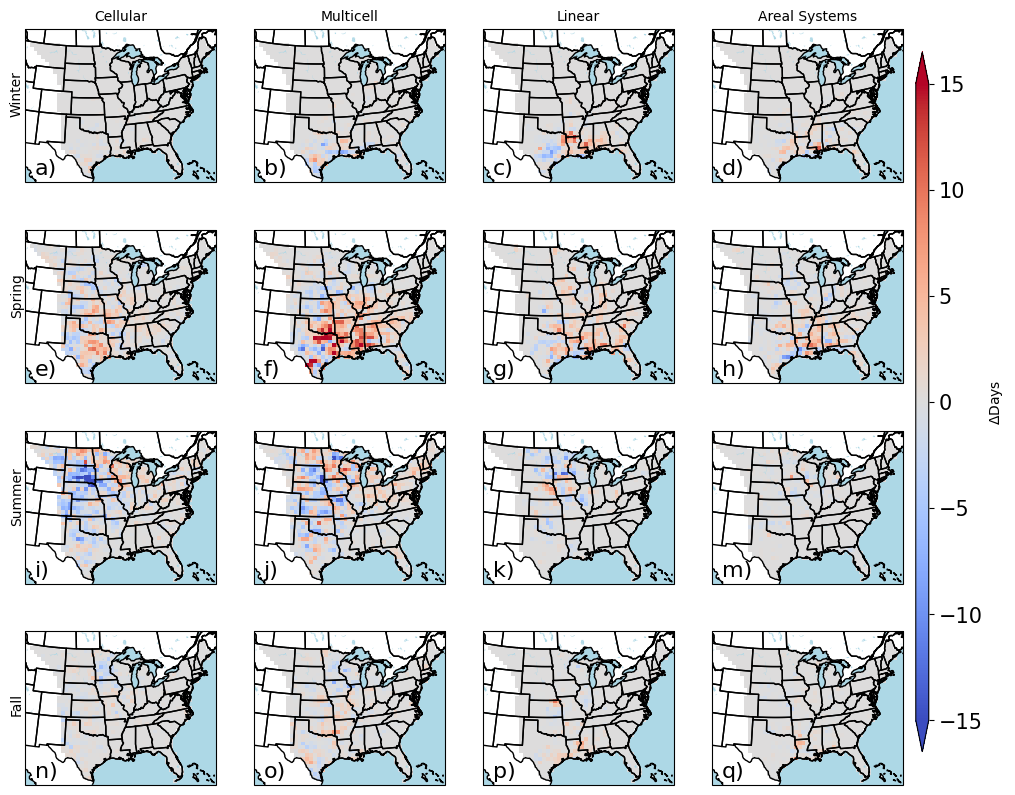

In [21]:
from matplotlib import colors
letter = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'm', 'n', 'o', 'p', 'q']

#Plot the data
fig = plt.figure()
plt.rcParams['figure.figsize'] = 13,10
divnorm=colors.TwoSlopeNorm(vmin=-15., vcenter=0., vmax=15)
plt.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.15, 0.01, 0.7])

rcp = 4 
i = 1

#iterate through the modes and seasons
for season in seasons:
    for mode in modes:
        plt.tick_params(left = False, right = False , labelleft = False ,
                    labelbottom = False, bottom = False)

        ax = plt.subplot(4, 4, i, projection=ccrs.LambertConformal(central_longitude=-98, central_latitude=35))
        c = ax.pcolormesh(ds_cov_Cellular_eoc4p5_Winter.lon.values, ds_cov_Cellular_eoc4p5_Winter.lat.values, locals()[f'delta_{rcp}p5_hist_{mode}_{season}'],
                          transform=cartopy.crs.PlateCarree(), cmap='coolwarm', norm=divnorm)
        if i <= 4:
            ax.set_title(f'{mode}',fontsize=10)
            
        ax.add_feature(cartopy.feature.STATES, zorder=2)
        ax.add_feature(cartopy.feature.COASTLINE)
        ax.add_feature(cartopy.feature.LAND, facecolor='white')
        ax.add_feature(cartopy.feature.OCEAN, facecolor='lightblue')
        ax.add_feature(cartopy.feature.LAKES, facecolor='lightblue')

        ax.set_extent([-110, -74, 24.5, 50])
        
        ax.annotate(f'{letter[i-1]})', (0.05,0.05),fontsize=16, xycoords='axes fraction')

        
        if i == 1:
            ax.annotate('Winter', xy=(-0.08,0.45), xycoords='axes fraction', fontsize=10, rotation='vertical')
            
        elif i == 5:
            ax.annotate('Spring', xy=(-0.08,0.45), xycoords='axes fraction', fontsize=10, rotation='vertical')
        
        elif i == 9:
            ax.annotate('Summer', xy=(-0.08,0.4), xycoords='axes fraction', fontsize=10, rotation='vertical')

        elif i == 13:
            ax.annotate('Fall', xy=(-0.08,0.47), xycoords='axes fraction', fontsize=10, rotation='vertical')
            
        i = i +1



cbar = plt.colorbar(c, ticks=list(range(-30, 31, 5)), pad=0.01, extend='both', ax=ax, cax=cbar_ax)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(label='$\Delta$Days', size=10)
plt.show()

In [22]:
fig.savefig('RCP4p5_deltas.png', format='png', dpi=1000)

## RCP 8.5

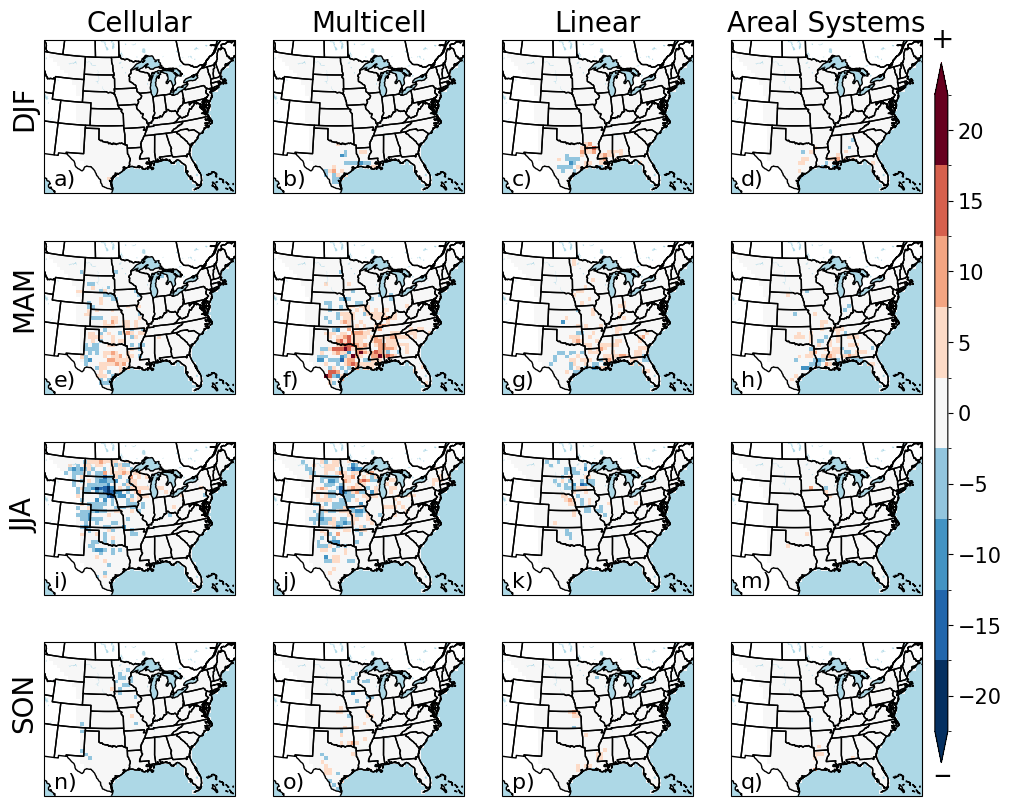

In [73]:
from matplotlib import colors
letter = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'm', 'n', 'o', 'p', 'q']

#Plot the data
fig = plt.figure()
plt.rcParams['figure.figsize'] = 13,10
divnorm=colors.TwoSlopeNorm(vmin=-15., vcenter=0., vmax=15)
plt.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.15, 0.01, 0.7])

rcp = 8 
i = 1

#iterate through the modes and seasons
for season in seasons:
    for mode in modes:
        plt.tick_params(left = False, right = False , labelleft = False ,
                    labelbottom = False, bottom = False)

        ax = plt.subplot(4, 4, i, projection=ccrs.LambertConformal(central_longitude=-98, central_latitude=35))
        c = ax.pcolormesh(ds_cov_Cellular_eoc4p5_Winter.lon.values, ds_cov_Cellular_eoc4p5_Winter.lat.values, locals()[f'delta_{rcp}p5_hist_{mode}_{season}'],
                          transform=cartopy.crs.PlateCarree(), cmap=cmap, norm=norm)
        if i <= 4:
            ax.set_title(f'{mode}',fontsize=20)
            
        ax.add_feature(cartopy.feature.STATES, zorder=2)
        ax.add_feature(cartopy.feature.COASTLINE)
        ax.add_feature(cartopy.feature.LAND, facecolor='white')
        ax.add_feature(cartopy.feature.OCEAN, facecolor='lightblue')
        ax.add_feature(cartopy.feature.LAKES, facecolor='lightblue')

        ax.set_extent([-110, -74, 24.5, 50])
        
        ax.annotate(f'{letter[i-1]})', (0.05,0.05),fontsize=16, xycoords='axes fraction')

        
        if i == 1:
            ax.annotate('DJF', xy=(-0.18,0.45), xycoords='axes fraction', fontsize=20, rotation='vertical')
            
        elif i == 5:
            ax.annotate('MAM', xy=(-0.18,0.45), xycoords='axes fraction', fontsize=20, rotation='vertical')
        
        elif i == 9:
            ax.annotate('JJA', xy=(-0.18,0.45), xycoords='axes fraction', fontsize=20, rotation='vertical')

        elif i == 13:
            ax.annotate('SON', xy=(-0.18,0.45), xycoords='axes fraction', fontsize=20, rotation='vertical')
            
        elif i == 4:
            ax.annotate('+', xy=(1.05,0.95), xycoords='axes fraction', fontsize=20)
            
        elif i == 16:
            ax.annotate('_', xy=(1.07,0.17), xycoords='axes fraction', fontsize=20)
            
        i = i +1


        
cbar = plt.colorbar(c, ticks=list(range(-20, 21, 5)), pad=0.01, extend='both', ax=ax, cax=cbar_ax)
cbar.ax.tick_params(labelsize=15)
#cbar.set_label(label='$\Delta$Days', size=10)
plt.show()

In [74]:
fig.savefig('RCP8p5_deltas.jpg', format='jpg', dpi=1000, bbox_inches='tight')